In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import pandas as pd
import matplotlib as mpl
import rebound
import initialConditionsBuilder as IC # make sure to have this in the same directory

# I. Initial conditions

In [10]:
nParticles      = 100                 # number of particles
alphas          = [-0.3,-1.3,-2.35]   # Krouppa IMF power indices
mass_intervals  = [0.01,0.1,1,50]     # intervals for Krouppa IMF
R0              = 0.5*u.pc            # core radius in pc of the Plummer model

ic = IC.initialConditions(nParticles) # create initial conditions objects

ic.sample_piecewise_powerlaw(alphas = alphas, mass_intervals = mass_intervals) # create mass distribution (in solar masses)

ic.build_phasespace(nDim = 3,R0 = R0, model = 'plummer') # create Plummer sphere positions and velocities (in m and m/s)

posVels = ic.posVels                                        # extract positions and velocities (x,y,z,vx,vy,vz) in m and m/s
masses = ic.masses                                          # extract masses in solar masses
particles = np.concatenate((posVels,masses.reshape(1, -1))) # join masses with positions and velocities into one array

cluster = pd.DataFrame(particles.T,columns=['x','y','z','vx','vy','vz','mass']) # We store the initial conditions into a dataframe

# II. Initialize the N-body simulation in Rebound

In [ ]:
# We go from m to pc and s to yr
cluster['x'] = (cluster.x.to_numpy()*u.m).to(u.pc).value
cluster['y'] = (cluster.y.to_numpy()*u.m).to(u.pc).value
cluster['z'] = (cluster.z.to_numpy()*u.m).to(u.pc).value
cluster['vx'] = (cluster.vx.to_numpy()*u.m/u.s).to(u.pc/u.yr).value
cluster['vy'] = (cluster.vy.to_numpy()*u.m/u.s).to(u.pc/u.yr).value
cluster['vz'] = (cluster.vz.to_numpy()*u.m/u.s).to(u.pc/u.yr).value
cluster['particle_id'] = np.arange(0,nParticles,1)

# We initialize the simulation with units pc, yr and Msun
sim           = rebound.Simulation()
sim.units     = ('pc', 'yr', 'Msun')

# We store the initial conditions into the simulator (with the particles ids)
for particleId in cluster.particle_id:
    particle = cluster[cluster.particle_id == particleId]
    sim.add(m = particle.mass.iloc[0], 
            x = particle.x.iloc[0], 
            y = particle.y.iloc[0], 
            z = particle.z.iloc[0], 
            vx = particle.vx.iloc[0], 
            vy = particle.vy.iloc[0], 
            vz = particle.vz.iloc[0], 
            hash = f'{particleId}')

# III. Simulation run

In [11]:
Nout   = int(1e4)                       # Number of steps
times  = np.linspace(0, int(5e7), Nout) # integration time steps

# We run the N-body and store the information of each snapshot with its corresponding energy
x, y, z, vx, vy, vz   = np.zeros([nParticles,Nout]), np.zeros([nParticles,Nout]), np.zeros([nParticles,Nout]), np.zeros([nParticles,Nout]), np.zeros([nParticles,Nout]), np.zeros([nParticles,Nout])
energy = pd.DataFrame()
for j, t in enumerate(times):
    sim.move_to_com()
    kineticEnergy = 0
    sim.integrate(t)
    for particleId in cluster.particle_id:
        x[particleId,j]  = sim.particles[f'{particleId}'].x
        y[particleId,j]  = sim.particles[f'{particleId}'].y
        z[particleId,j]  = sim.particles[f'{particleId}'].z
        vx[particleId,j] = sim.particles[f'{particleId}'].vx
        vy[particleId,j] = sim.particles[f'{particleId}'].vy
        vz[particleId,j] = sim.particles[f'{particleId}'].vz
        kineticEnergy   += 0.5*sim.particles[f'{particleId}'].m*(sim.particles[f'{particleId}'].vx**2+sim.particles[f'{particleId}'].vy**2+sim.particles[f'{particleId}'].vz**2)
    energy = pd.concat([energy,pd.DataFrame({'t':[t],
                                             'kinetic':[kineticEnergy],
                                             'total':[sim.energy()]})],axis=0).reset_index(drop = True)


# IV. Trajectories

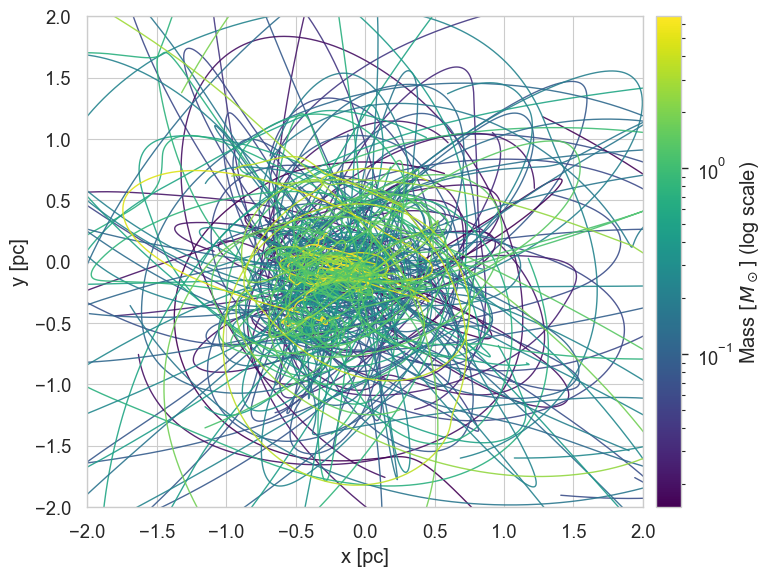

In [14]:
ids = list(cluster.particle_id)

# masses in same order as ids
try:
    masses = np.asarray(cluster.mass)[ids]
except Exception:
    masses = np.array([cluster.mass[i] for i in ids], dtype=float)

# LogNorm needs >0
mpos = masses[masses > 0]
vmin = mpos.min()
vmax = masses.max()

norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = mpl.cm.viridis
colors = [cmap(norm(max(m, vmin))) for m in masses]

fig, ax = plt.subplots(figsize=(8,6))

for pid, col in zip(ids, colors):
    ax.plot(x[pid, :], y[pid, :], lw=1, color=col, alpha=0.9)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
# ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x [pc]')
ax.set_ylabel('y [pc]')

# colorbar: bind to this axes via fig.colorbar(..., ax=ax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r'Mass $[M_\odot]$ (log scale)')

fig.tight_layout()
fig.savefig("x_vs_y_mass_logcolor.jpg", dpi=200, bbox_inches='tight')
plt.show()

# V. Distances to center of mass

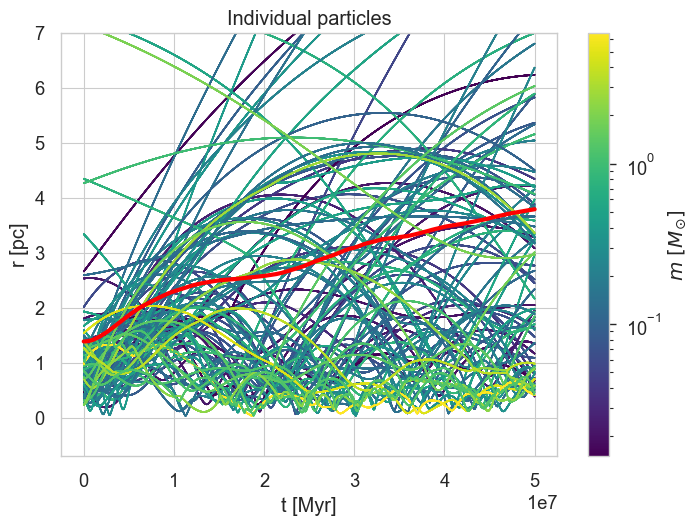

In [18]:
plt.plot(energy.t,np.sqrt(x**2+y**2+z**2).mean(axis=0),color='red',zorder=1000,linewidth=3)
for particleId in cluster.particle_id:
    sc = plt.scatter(energy.t,np.sqrt(x[particleId,:]**2+y[particleId,:]**2+z[particleId,:]**2),c=sim.particles[f'{particleId}'].m*np.ones(x.shape[1]),cmap='viridis',s=0.1,norm=mpl.colors.LogNorm(vmin=cluster.mass.min(), vmax=cluster.mass.max()))
plt.xlabel('t [Myr]')
plt.ylabel('r [pc]')
plt.ylim(-0.7,7)
plt.colorbar(sc,label=r'$m~[M_{\odot}]$')
plt.title('Individual particles')
plt.savefig("r_vs_t_all_particles_rebound.jpg",bbox_inches='tight')
plt.show()




# VI. Average distances to center of mass of different mass bin

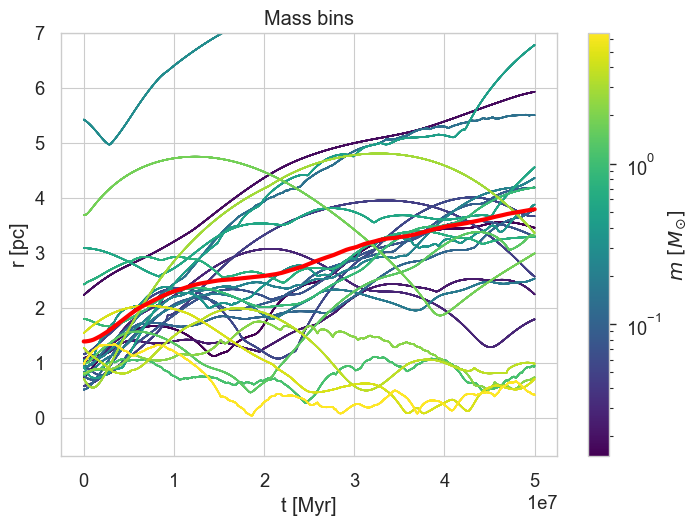

In [19]:
logdm    = 0.1
logmBins = np.arange(-2,1,logdm) 
plt.plot(energy.t,np.sqrt(x**2+y**2+z**2).mean(axis=0),color='red',zorder=1000,linewidth=3)
for logmbin in logmBins:
    mMin = 10**(logmbin)
    mMax = 10**(logmbin+logdm)
    indexes      = cluster[(cluster.mass > mMin) & (cluster.mass <= mMax)].index
    meanDistance = np.zeros(x.shape[1])
    if len(indexes) > 0:
        for particleId in indexes:
            meanDistance += np.sqrt(x[particleId,:]**2+y[particleId,:]**2+z[particleId,:]**2)
        meanDistance = meanDistance/len(indexes)
        sc = plt.scatter(energy.t,meanDistance,c=(mMax+mMin)*np.ones(x.shape[1])/2,cmap='viridis',s=0.1,norm=mpl.colors.LogNorm(vmin=cluster.mass.min(), vmax=cluster.mass.max()))
plt.xlabel('t [Myr]')
plt.ylabel('r [pc]')
plt.ylim(-0.7,7)
plt.colorbar(sc,label=r'$m~[M_{\odot}]$')
plt.title('Mass bins')
plt.savefig("r_vs_t_all_mass_bins_rebound.jpg",bbox_inches='tight')
plt.show()

# VII. Fractional error estimate from total energy conservation

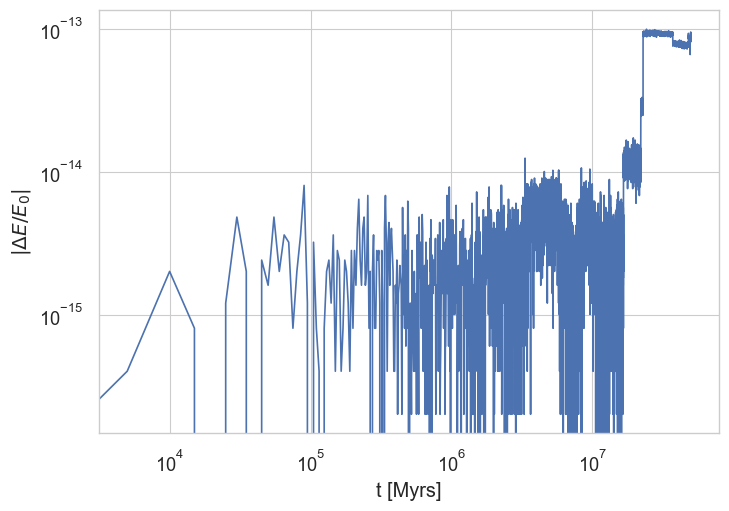

In [21]:
plt.plot(energy.t,np.abs((energy.total-energy.total.iloc[0])/energy.total.iloc[0]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t [Myrs]')
plt.ylabel(r'$|\Delta E/E_0|$')
plt.savefig("dE_E_vs_t.jpg",bbox_inches='tight')
plt.show()

# VIII. Cluster boundedness estimate through Virial ratio

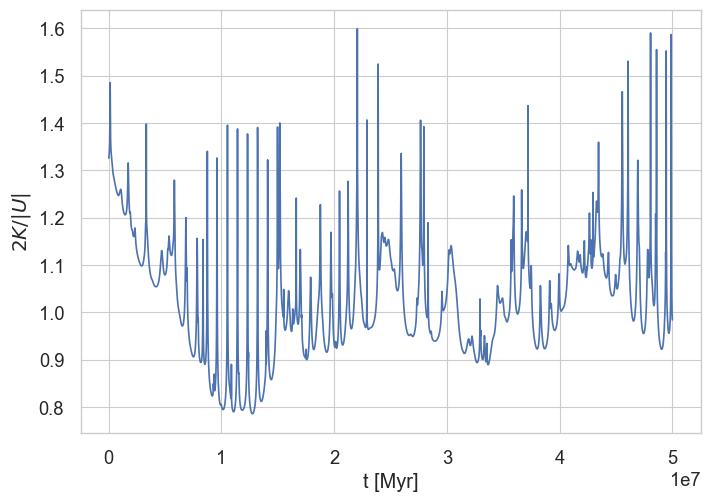

In [24]:
fig, ax = plt.subplots()
ax.plot(energy.t, 2*energy.kinetic/np.abs(energy.total - energy.kinetic))
ax.set_xlabel('t [Myr]')
ax.set_ylabel(r'$2K/|U|$')

# disable scientific/offset formatting on y (and x if you want)
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
# ax.ticklabel_format(axis='x', style='plain', useOffset=False)

plt.show()